# Simple convolutional neural network for image classification: fashion-MNIST

#### Parameters

In [1]:
# Dimension of images
image_width = 28
image_height = 28
channel = 1

# Parameters for learning
batch_size = 200
epoch = 3
itr = 3
augmentation = 2   # defines the number of additional augmentations of one image

# Data
fashion_cls = {0: "T-shirt/Top",
               1: "Trouser",
               2: "Pullover",
               3: "Dress",
               4: "Coat",
               5: "Sandal",
               6: "Shirt",
               7: "Sneaker",
               8: "Bag",
               9: "Ankle boot"}
mnist_cls = [i for i in range(10)]
num_cls = 10

#### Loading data
Using Tensorflow Dataset for loading Fashion-MNIST

In [2]:
import tensorflow_datasets as tfds

# Train
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Train Samples: 60000
Test Samples: 10000


#### Plot random sample

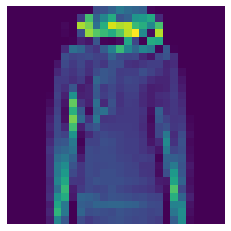

Target: Pullover


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]))
plt.axis('off')
plt.show()

print("Target:", fashion_cls[y_train[idx]])

#### Data augmentation (optional)
This method will increase the raw data by data augmentation of images. I just added rotation, horizontal flip and fill mode. Feel free to change this settings.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True) # delete fill_mode='nearest'

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : raw image
    nb_augmentation: number of augmentations
    images: array with new images
    '''
    images = []
    image = image.reshape(1, image_height, image_width, channel)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1): # datagen.flow() Generate batches of tensor image data with real-time data augmentation
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

#### Preprocess data
Processing of raw images:
- Scaling pixels between 0.0-1.0
- Add augmentated images

In [5]:
import tensorflow as tf

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: raw image
    targets: target label
    use_augmentation: True if augmentation should be used
    nb_of_augmentation: If use_augmentation=True, number of augmentations
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):
        
        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.
        
        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(image_height, image_width, channel))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed:', len(X),' samples')
    return np.array(X), tf.keras.utils.to_categorical(y) # tf.keras.utils.to_categorical(y) Converts a class vector (integers) to binary class matrix.


In [6]:
X_train_shaped, y_train_shaped = preprocess_data(X_train, y_train, use_augmentation=True, 
                                                    nb_of_augmentation=augmentation)

X_test_shaped, y_test_shaped   = preprocess_data(X_test,  y_test)

*Preprocessing completed: 180000  samples
*Preprocessing completed: 10000  samples


#### Model definition

In [7]:
def create_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(image_height,image_width,channel)))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='sigmoid'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_cls, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

    return cnn

create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0

##### Run training
Run training for number of iterations by random data for train/validation. The best model of each iteration will be saved as hdf5 checkpoint.

In [8]:
from sklearn.model_selection import train_test_split

histories = []

for i in range(0,itr):
    print('Running iteration:',i)
    
    # Saving the best checkpoint for each iteration
    filepath = "fashion_mnist-%i.hdf5" % i
    
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                          test_size=0.2, random_state=42)
    
    cnn = create_model()
    history = cnn.fit(X_train_, y_train_, batch_size=batch_size, epochs=epoch,
        verbose=1,validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    
    histories.append(history.history)

Running iteration: 0
Epoch 1/3
720/720 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7434
Epoch 1: val_loss improved from inf to 0.34829, saving model to fashion_mnist-0.hdf5
720/720 [==============================] - 190s 257ms/step - loss: 0.7178 - accuracy: 0.7434 - val_loss: 0.3483 - val_accuracy: 0.8719
Epoch 2/3
720/720 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8568
Epoch 2: val_loss improved from 0.34829 to 0.29056, saving model to fashion_mnist-0.hdf5
720/720 [==============================] - 182s 253ms/step - loss: 0.3908 - accuracy: 0.8568 - val_loss: 0.2906 - val_accuracy: 0.8915
Epoch 3/3
720/720 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8743
Epoch 3: val_loss improved from 0.29056 to 0.28045, saving model to fashion_mnist-0.hdf5
720/720 [==============================] - 188s 261ms/step - loss: 0.3430 - accuracy: 0.8743 - val_loss: 0.2805 - val_accuracy: 0.8947
Running iteration: 1
Epoch

# Evaluation

#### Trainingscores for loss and accuracy for all checkpoints
Remind that checkpoints will be saved by minimum loss.

In [9]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training:\t', get_avg(histories,'loss'), 'loss /', get_avg(histories,'accuracy'), 'acc')
print('Validation: \t', get_avg(histories,'val_loss'), 'loss /', get_avg(histories,'val_accuracy'), 'acc')

Training:	 0.3405321737130483 loss / 0.8753495415051779 acc
Validation: 	 0.27433550357818604 loss / 0.8970740834871928 acc


#### Loss / accuracy of all models on testset
Determine loss and accuracy of all models.

In [10]:
test_loss = []
test_accs = []

for i in range(0,itr):
    cnn_ = tf.keras.models.load_model("fashion_mnist-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 0: 0.2989 loss / 0.8901 acc
Running final test with model 1: 0.2881 loss / 0.8947 acc
Running final test with model 2: 0.2979 loss / 0.8930 acc

Average loss / accuracy on testset: 0.2950 loss / 0.89260 acc
Standard deviation: (+-0.0049) loss / (+-0.0019) acc


##### Plotting accuracy and loss for each iteration

In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

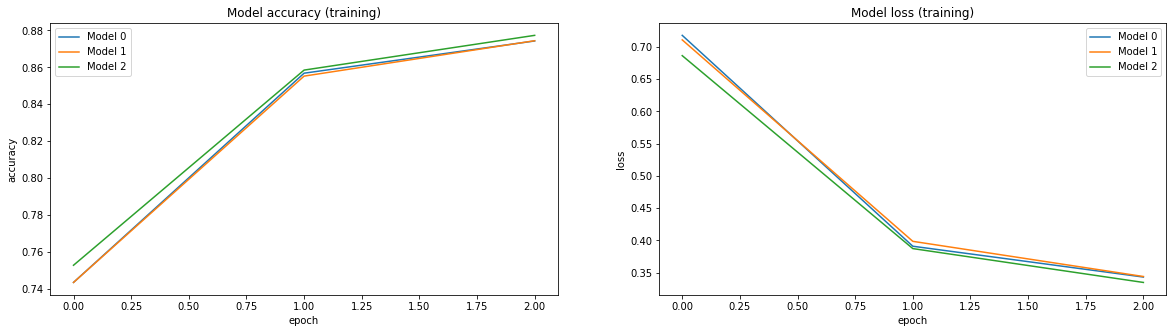

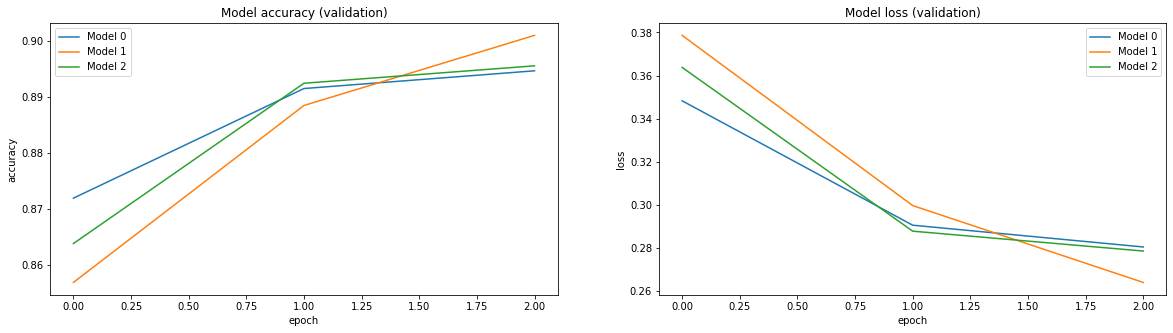

In [12]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

## Evaluation for one model

In [13]:
RUN = 0 # you can choose one of the different models trained above
model = create_model()
model.load_weights("fashion_mnist-%i.hdf5" % RUN)

##### Plotting accuracy and loss for one model

In [14]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

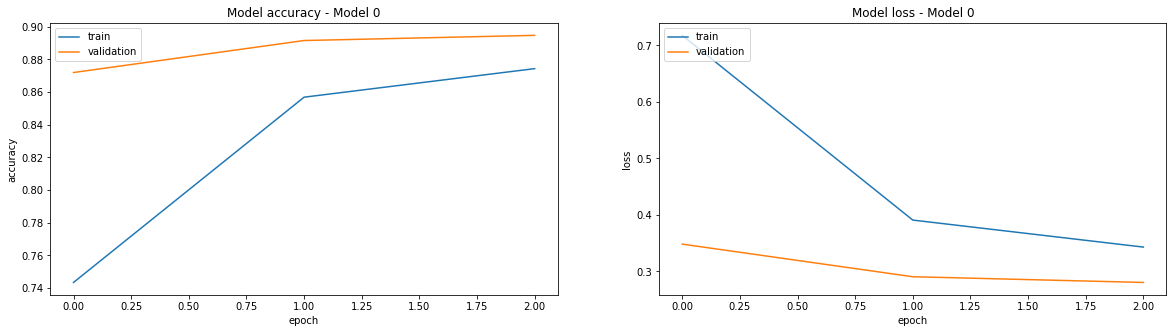

In [15]:
plot_train_val('Model %i' % RUN, histories[RUN])

##### Displaying results of random predictions


In [16]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row
    
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):
            
            elements = np.squeeze(np.argwhere(y_test==class_))
            random   = np.random.randint(len(elements))
            
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)
            
            x_reshape = X.reshape([1,image_height,image_width,channel])
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X))
            axis.axis('off')
            class_ +=1
    plt.show()

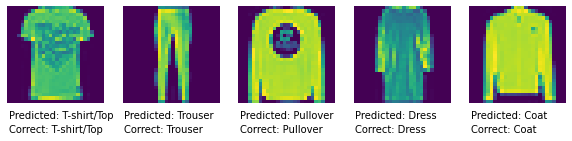

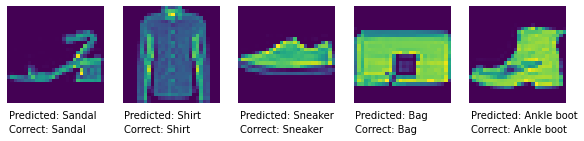

In [17]:
plot_sample_predictions(list(fashion_cls.values()), model, X_test_shaped, y_test)

##### Plotting confusion matrix


In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

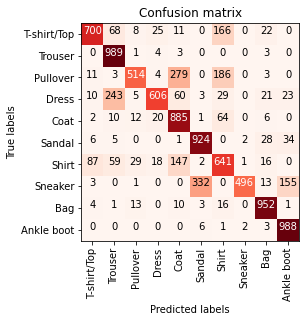

In [19]:
predictions = model.predict(X_test)
classes_x=np.argmax(predictions,axis=1)
plot_confusion_matrix(confusion_matrix(y_test,classes_x), list(fashion_cls.values()))

##### Report of f1, precision and recall

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1000
           1       0.72      0.99      0.83      1000
           2       0.88      0.51      0.65      1000
           3       0.90      0.61      0.72      1000
           4       0.63      0.89      0.74      1000
           5       0.73      0.92      0.81      1000
           6       0.58      0.64      0.61      1000
           7       0.99      0.50      0.66      1000
           8       0.89      0.95      0.92      1000
           9       0.82      0.99      0.90      1000

    accuracy                           0.77     10000
   macro avg       0.80      0.77      0.76     10000
weighted avg       0.80      0.77      0.76     10000

